# Query A

__Afficher le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).__

In [1]:
#!pip install folium

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import json

from pyspark import SparkContext
from pyspark.sql import SQLContext

import folium

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.11:2.3.0 --conf spark.cassandra.connection.host=172.31.81.83 pyspark-shell'

In [4]:
sc = SparkContext("local", "gdelt")
sqlContext = SQLContext(sc)

In [5]:
def load_and_get_table_df(keys_space_name, table_name):
    table_df = sqlContext.read\
        .format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keys_space_name)\
        .load()
    return table_df

In [6]:
querya = load_and_get_table_df('gdelt', 'querya')
# sqlContext.read.csv('s3://fufu-program/bigdata/reqA_csv')
querya.count()

123980

# Evénement sur un jour donnée

In [7]:
onDay = '20190601'

In [8]:
dayValue = querya.where("sqldate == '%s'" % onDay).collect()
df = pd.DataFrame(dayValue, columns=('sqldate', 'iso_a2', 'number_events', 'language'))

In [9]:
df.sort_values('number_events', ascending=False).head(10)

,sqldate,iso_a2,number_events,language
17,20190601,US,39326,
73,20190601,UK,5707,
100,20190601,IN,5165,
142,20190601,CA,3376,
124,20190601,CH,3347,
91,20190601,,3193,
160,20190601,NI,2804,
49,20190601,MX,2273,
117,20190601,RS,2261,
25,20190601,IS,2247,


In [10]:
df.sort_values('number_events', ascending=False).iloc[1:, :].head()

,sqldate,iso_a2,number_events,language
73,20190601,UK,5707,
100,20190601,IN,5165,
142,20190601,CA,3376,
124,20190601,CH,3347,
91,20190601,,3193,


In [11]:
m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=f"./world-countries.geo.json",
    name='choropleth',
    data=df.sort_values('number_events', ascending=False).iloc[1:, :],
    columns=['iso_a2', 'number_events'],
    key_on='feature.properties.iso_a2',
    fill_color='YlGn',
    fill_opacity=0.5,
    line_opacity=0.7,
    legend_name='Number of events'
).add_to(m)

print('Events outside of USA on %s' % onDay)
m

Events outside of USA on 20190601


# Evénements aux USA au début d'année 2019

In [12]:
usCounts = querya.where("country == 'US'")

In [13]:
dfUs = pd.DataFrame(usCounts.collect(), columns=('sqldate', 'iso_a2', 'number_events', 'language'))

In [14]:
dfUs['sqldate'] = pd.to_datetime(dfUs['sqldate'], format="%Y%m%d")
dfUsFiltered = dfUs[(dfUs['sqldate'] >= '2019-01-01') & (dfUs['sqldate'] < '2019-02-01')].set_index('sqldate')

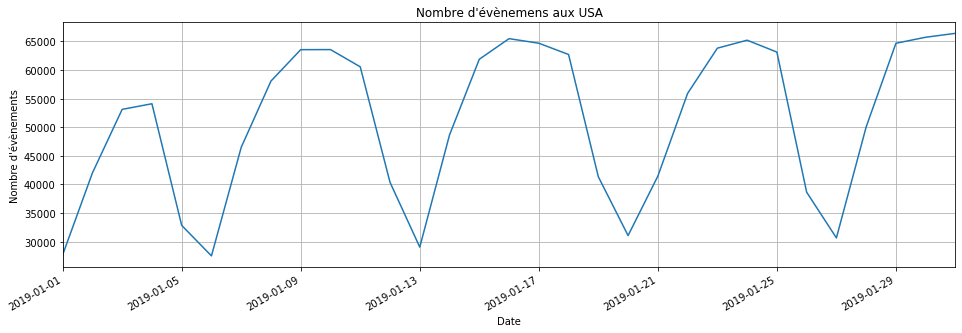

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))
dfUsFiltered['number_events'].plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel("Nombre d'évènements")
ax.set_title("Nombre d'évènemens aux USA")
ax.grid()